<h1>Model: Female Anger vs. Others</h1>

In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [4]:
def getEmotionCode(x):
    part = x.split('_')
    if part[3] == 'ANG':
        return 1
    else:
        return 0

def getEmotion(x):
    if x == 1:
        return 'ANG'
    else:
        return 'OTH'
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

# Ytrain in Onehot encoded form 
def makeOverSamplesSMOTE(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original trainingset shape %s' %  [(getEmotion(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    sm = SMOTE(sampling_strategy='all',k_neighbors=5)
    X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getEmotion(k),v) for k,v in Counter(Y_train_labelled).items()])

    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=2)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    return(X_train,Y_train)

In [5]:
X_all = []
Y_all = []

image_folder_path = '../cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    split_file_name = file_name.split('_')
    if split_file_name[0] == 'M':
        spectrogram = Image.open(image_folder_path + '/' + file_name)
        spectrogram = spectrogram.convert('L')
        spectrogram = spectrogram.resize((167, 109))
        spectrogram = np.array(spectrogram)
        spectrogram = np.expand_dims(spectrogram, axis=2)
        X_all.append(spectrogram)
        Y_all.append(getEmotionCode(file_name))
    


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)



X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=2)

print(X_all.shape)
print(Y_all.shape)



(3930, 109, 167, 1)
(3930, 2)


In [7]:
# train /test= 80/20% split
# stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123, stratify=Y_all)



<h2>Keras Tuner</h2>

In [8]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        c1 = Convolution2D(filters=hp.Int('conv1',
                                 min_value=64,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv1size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=7),
                           strides=(2,2),padding='same')(inp)
        
        bt = BatchNormalization()(c1)
        bt = Activation('relu')(bt)
        mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.2)(mpool)

        #conv2
        c2 = Convolution2D(filters=hp.Int('conv2',
                                 min_value=64,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv2size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=5),
                           strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.3)(mpool)
        
        #conv3
        c2 = Convolution2D(filters=hp.Int('conv3',
                                 min_value=64,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv3size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=3),
                           strides=(2,2),padding='same')(mpool)
        
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.3)(mpool)

        #Conv 4
        c3 = Convolution2D(filters=hp.Int('conv4',
                                 min_value=64,
                                 max_value=512,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv4size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=3),
                           strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c3)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.4)(mpool)

        f = Flatten()(mpool)

        x_dense = Dense(256)(f)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.4)(bt)


        x_dense = Dense(64)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.2)(bt)

        x_out = Dense(2, name='output', activation='softmax')(bt)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [9]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(109,167,1), num_classes=2)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=1,
    max_trials=6,
    executions_per_trial=2,
    directory='random_search',
    project_name='male_and_others_5_oct'
)

In [10]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Epoch 1/70
354/354 - 14s - loss: 0.4292 - accuracy: 0.8130 - val_loss: 0.4562 - val_accuracy: 0.8000
Epoch 2/70
354/354 - 2s - loss: 0.3553 - accuracy: 0.8431 - val_loss: 0.2980 - val_accuracy: 0.8667
Epoch 3/70
354/354 - 2s - loss: 0.3429 - accuracy: 0.8420 - val_loss: 0.3445 - val_accuracy: 0.8635
Epoch 4/70
354/354 - 2s - loss: 0.3225 - accuracy: 0.8512 - val_loss: 0.2729 - val_accuracy: 0.8984
Epoch 5/70
354/354 - 2s - loss: 0.3235 - accuracy: 0.8590 - val_loss: 0.2612 - val_accuracy: 0.8984
Epoch 6/70
354/354 - 2s - loss: 0.3292 - accuracy: 0.8551 - val_loss: 0.2706 - val_accuracy: 0.8921
Epoch 7/70
354/354 - 2s - loss: 0.3062 - accuracy: 0.8671 - val_loss: 0.3424 - val_accuracy: 0.8254
Epoch 8/70
354/354 - 2s - loss: 0.3037 - accuracy: 0.8699 - val_loss: 0.3052 - val_accuracy: 0.8762
Epoch 9/70
354/354 - 2s - loss: 0.3019 - accuracy: 0.8692 - val_loss: 0.2716 - val_accuracy: 0.8857
Epoch 10/70
354/354 - 2s - loss: 0.2921 - accuracy: 0.8752 - val_loss: 0.3680 - val_accuracy: 0.847

Epoch 13/70
354/354 - 2s - loss: 0.2975 - accuracy: 0.8770 - val_loss: 0.3037 - val_accuracy: 0.8540
Epoch 14/70
354/354 - 2s - loss: 0.2811 - accuracy: 0.8773 - val_loss: 0.2609 - val_accuracy: 0.9048
Epoch 15/70
354/354 - 2s - loss: 0.2737 - accuracy: 0.8876 - val_loss: 0.7778 - val_accuracy: 0.6540
Epoch 16/70
354/354 - 2s - loss: 0.2761 - accuracy: 0.8844 - val_loss: 0.2323 - val_accuracy: 0.8984
Epoch 17/70
354/354 - 2s - loss: 0.2740 - accuracy: 0.8816 - val_loss: 0.2474 - val_accuracy: 0.9048
Epoch 18/70
354/354 - 2s - loss: 0.2779 - accuracy: 0.8788 - val_loss: 0.2423 - val_accuracy: 0.9175
Epoch 19/70
354/354 - 2s - loss: 0.2745 - accuracy: 0.8894 - val_loss: 0.2521 - val_accuracy: 0.9048
Epoch 20/70
354/354 - 2s - loss: 0.2704 - accuracy: 0.8901 - val_loss: 0.2224 - val_accuracy: 0.9016
Epoch 21/70
354/354 - 2s - loss: 0.2691 - accuracy: 0.8901 - val_loss: 0.2233 - val_accuracy: 0.9016
Epoch 22/70
354/354 - 2s - loss: 0.2550 - accuracy: 0.8929 - val_loss: 0.2257 - val_accurac

Epoch 1/70
354/354 - 15s - loss: 0.4311 - accuracy: 0.7978 - val_loss: 0.9696 - val_accuracy: 0.8000
Epoch 2/70
354/354 - 3s - loss: 0.3622 - accuracy: 0.8392 - val_loss: 0.7402 - val_accuracy: 0.8000
Epoch 3/70
354/354 - 3s - loss: 0.3388 - accuracy: 0.8484 - val_loss: 0.3157 - val_accuracy: 0.8698
Epoch 4/70
354/354 - 3s - loss: 0.3388 - accuracy: 0.8462 - val_loss: 0.2996 - val_accuracy: 0.8730
Epoch 5/70
354/354 - 3s - loss: 0.3210 - accuracy: 0.8590 - val_loss: 0.3869 - val_accuracy: 0.8349
Epoch 6/70
354/354 - 3s - loss: 0.3293 - accuracy: 0.8519 - val_loss: 0.2919 - val_accuracy: 0.8698
Epoch 7/70
354/354 - 3s - loss: 0.3079 - accuracy: 0.8674 - val_loss: 0.3072 - val_accuracy: 0.8857
Epoch 8/70
354/354 - 3s - loss: 0.3121 - accuracy: 0.8643 - val_loss: 0.3282 - val_accuracy: 0.8476
Epoch 9/70
354/354 - 3s - loss: 0.2991 - accuracy: 0.8717 - val_loss: 0.3873 - val_accuracy: 0.8540
Epoch 10/70
354/354 - 3s - loss: 0.2995 - accuracy: 0.8699 - val_loss: 0.2885 - val_accuracy: 0.876

Epoch 13/70
354/354 - 3s - loss: 0.2990 - accuracy: 0.8689 - val_loss: 0.2649 - val_accuracy: 0.8952
Epoch 14/70
354/354 - 3s - loss: 0.3031 - accuracy: 0.8664 - val_loss: 0.3855 - val_accuracy: 0.7937
Epoch 15/70
354/354 - 3s - loss: 0.2895 - accuracy: 0.8713 - val_loss: 0.2636 - val_accuracy: 0.8794
Epoch 16/70
354/354 - 3s - loss: 0.2865 - accuracy: 0.8812 - val_loss: 0.4091 - val_accuracy: 0.7714
Epoch 17/70
354/354 - 3s - loss: 0.2823 - accuracy: 0.8780 - val_loss: 0.5017 - val_accuracy: 0.8444
Epoch 18/70
354/354 - 3s - loss: 0.2828 - accuracy: 0.8872 - val_loss: 0.2976 - val_accuracy: 0.8762
Epoch 19/70
354/354 - 3s - loss: 0.2825 - accuracy: 0.8834 - val_loss: 0.2608 - val_accuracy: 0.8794
Epoch 20/70
354/354 - 3s - loss: 0.2655 - accuracy: 0.8911 - val_loss: 0.2657 - val_accuracy: 0.8921
Epoch 21/70
354/354 - 3s - loss: 0.2586 - accuracy: 0.8925 - val_loss: 0.2681 - val_accuracy: 0.8667
Epoch 22/70
354/354 - 3s - loss: 0.2720 - accuracy: 0.8901 - val_loss: 0.2547 - val_accurac

Epoch 1/70
354/354 - 16s - loss: 0.4348 - accuracy: 0.7950 - val_loss: 1.3035 - val_accuracy: 0.8000
Epoch 2/70
354/354 - 4s - loss: 0.3499 - accuracy: 0.8512 - val_loss: 0.2838 - val_accuracy: 0.8794
Epoch 3/70
354/354 - 4s - loss: 0.3289 - accuracy: 0.8519 - val_loss: 0.3134 - val_accuracy: 0.8635
Epoch 4/70
354/354 - 4s - loss: 0.3291 - accuracy: 0.8491 - val_loss: 0.4878 - val_accuracy: 0.7651
Epoch 5/70
354/354 - 4s - loss: 0.3150 - accuracy: 0.8547 - val_loss: 0.2884 - val_accuracy: 0.8857
Epoch 6/70
354/354 - 4s - loss: 0.3135 - accuracy: 0.8628 - val_loss: 0.2775 - val_accuracy: 0.8889
Epoch 7/70
354/354 - 4s - loss: 0.3130 - accuracy: 0.8632 - val_loss: 0.3034 - val_accuracy: 0.8698
Epoch 8/70
354/354 - 4s - loss: 0.3094 - accuracy: 0.8618 - val_loss: 0.3032 - val_accuracy: 0.8317
Epoch 9/70
354/354 - 4s - loss: 0.3030 - accuracy: 0.8731 - val_loss: 0.2621 - val_accuracy: 0.8857
Epoch 10/70
354/354 - 5s - loss: 0.2849 - accuracy: 0.8742 - val_loss: 0.2784 - val_accuracy: 0.857

Epoch 13/70
354/354 - 5s - loss: 0.2964 - accuracy: 0.8773 - val_loss: 0.2662 - val_accuracy: 0.8952
Epoch 14/70
354/354 - 5s - loss: 0.2849 - accuracy: 0.8901 - val_loss: 0.2531 - val_accuracy: 0.9048
Epoch 15/70
354/354 - 5s - loss: 0.2694 - accuracy: 0.8876 - val_loss: 0.2845 - val_accuracy: 0.8667
Epoch 16/70
354/354 - 5s - loss: 0.2732 - accuracy: 0.8834 - val_loss: 0.2600 - val_accuracy: 0.8952
Epoch 17/70
354/354 - 5s - loss: 0.2672 - accuracy: 0.8862 - val_loss: 0.2340 - val_accuracy: 0.8952
Epoch 18/70
354/354 - 5s - loss: 0.2604 - accuracy: 0.8872 - val_loss: 0.7822 - val_accuracy: 0.6476
Epoch 19/70
354/354 - 5s - loss: 0.2646 - accuracy: 0.8894 - val_loss: 0.3454 - val_accuracy: 0.8444
Epoch 20/70
354/354 - 5s - loss: 0.2532 - accuracy: 0.8940 - val_loss: 0.3344 - val_accuracy: 0.8667
Epoch 21/70
354/354 - 5s - loss: 0.2426 - accuracy: 0.8964 - val_loss: 0.2793 - val_accuracy: 0.8857
Epoch 22/70
354/354 - 5s - loss: 0.2380 - accuracy: 0.9049 - val_loss: 0.2517 - val_accurac

Epoch 1/70
354/354 - 14s - loss: 0.4281 - accuracy: 0.8187 - val_loss: 1.0160 - val_accuracy: 0.8000
Epoch 2/70
354/354 - 2s - loss: 0.3729 - accuracy: 0.8378 - val_loss: 0.3076 - val_accuracy: 0.8413
Epoch 3/70
354/354 - 3s - loss: 0.3538 - accuracy: 0.8441 - val_loss: 0.2792 - val_accuracy: 0.8730
Epoch 4/70
354/354 - 2s - loss: 0.3354 - accuracy: 0.8512 - val_loss: 0.2841 - val_accuracy: 0.8857
Epoch 5/70
354/354 - 2s - loss: 0.3352 - accuracy: 0.8416 - val_loss: 0.3037 - val_accuracy: 0.8921
Epoch 6/70
354/354 - 2s - loss: 0.3285 - accuracy: 0.8491 - val_loss: 0.2845 - val_accuracy: 0.8857
Epoch 7/70
354/354 - 2s - loss: 0.3129 - accuracy: 0.8604 - val_loss: 0.3582 - val_accuracy: 0.8381
Epoch 8/70
354/354 - 3s - loss: 0.3168 - accuracy: 0.8575 - val_loss: 0.3005 - val_accuracy: 0.8857
Epoch 9/70
354/354 - 3s - loss: 0.3009 - accuracy: 0.8738 - val_loss: 0.5651 - val_accuracy: 0.8032
Epoch 10/70
354/354 - 3s - loss: 0.3095 - accuracy: 0.8611 - val_loss: 0.3368 - val_accuracy: 0.873

Epoch 13/70
354/354 - 2s - loss: 0.3010 - accuracy: 0.8671 - val_loss: 0.2398 - val_accuracy: 0.8921
Epoch 14/70
354/354 - 3s - loss: 0.2914 - accuracy: 0.8752 - val_loss: 0.2412 - val_accuracy: 0.9079
Epoch 15/70
354/354 - 3s - loss: 0.2849 - accuracy: 0.8784 - val_loss: 0.2753 - val_accuracy: 0.8825
Epoch 16/70
354/354 - 3s - loss: 0.2835 - accuracy: 0.8819 - val_loss: 0.3158 - val_accuracy: 0.8286
Epoch 17/70
354/354 - 2s - loss: 0.2815 - accuracy: 0.8830 - val_loss: 0.3055 - val_accuracy: 0.8825
Epoch 18/70
354/354 - 3s - loss: 0.2778 - accuracy: 0.8805 - val_loss: 0.3805 - val_accuracy: 0.8286
Epoch 19/70
354/354 - 3s - loss: 0.2744 - accuracy: 0.8816 - val_loss: 0.2464 - val_accuracy: 0.9016
Epoch 20/70
354/354 - 3s - loss: 0.2772 - accuracy: 0.8908 - val_loss: 0.4188 - val_accuracy: 0.8000
Epoch 21/70
354/354 - 2s - loss: 0.2589 - accuracy: 0.8936 - val_loss: 0.3300 - val_accuracy: 0.8540
Epoch 22/70
354/354 - 2s - loss: 0.2598 - accuracy: 0.8876 - val_loss: 0.2577 - val_accurac

Epoch 1/70
354/354 - 16s - loss: 0.4549 - accuracy: 0.7879 - val_loss: 0.6590 - val_accuracy: 0.8000
Epoch 2/70
354/354 - 3s - loss: 0.3507 - accuracy: 0.8423 - val_loss: 0.4784 - val_accuracy: 0.7619
Epoch 3/70
354/354 - 4s - loss: 0.3401 - accuracy: 0.8459 - val_loss: 0.3367 - val_accuracy: 0.8381
Epoch 4/70
354/354 - 3s - loss: 0.3355 - accuracy: 0.8526 - val_loss: 0.3951 - val_accuracy: 0.8095
Epoch 5/70
354/354 - 3s - loss: 0.3125 - accuracy: 0.8600 - val_loss: 0.5418 - val_accuracy: 0.8286
Epoch 6/70
354/354 - 3s - loss: 0.3076 - accuracy: 0.8678 - val_loss: 0.5864 - val_accuracy: 0.6413
Epoch 7/70
354/354 - 4s - loss: 0.3054 - accuracy: 0.8660 - val_loss: 0.2743 - val_accuracy: 0.8698
Epoch 8/70
354/354 - 4s - loss: 0.3096 - accuracy: 0.8727 - val_loss: 0.5574 - val_accuracy: 0.6571
Epoch 9/70
354/354 - 3s - loss: 0.3112 - accuracy: 0.8611 - val_loss: 0.3808 - val_accuracy: 0.8667
Epoch 10/70
354/354 - 3s - loss: 0.2946 - accuracy: 0.8777 - val_loss: 0.2662 - val_accuracy: 0.885

Epoch 13/70
354/354 - 4s - loss: 0.2920 - accuracy: 0.8759 - val_loss: 0.2587 - val_accuracy: 0.9111
Epoch 14/70
354/354 - 4s - loss: 0.2845 - accuracy: 0.8784 - val_loss: 0.2648 - val_accuracy: 0.8984
Epoch 15/70
354/354 - 4s - loss: 0.2741 - accuracy: 0.8773 - val_loss: 0.2848 - val_accuracy: 0.8571
Epoch 16/70
354/354 - 4s - loss: 0.2846 - accuracy: 0.8816 - val_loss: 0.3356 - val_accuracy: 0.8349
Epoch 17/70
354/354 - 4s - loss: 0.2794 - accuracy: 0.8841 - val_loss: 0.2544 - val_accuracy: 0.9048
Epoch 18/70
354/354 - 3s - loss: 0.2598 - accuracy: 0.8936 - val_loss: 0.3198 - val_accuracy: 0.8571
Epoch 19/70
354/354 - 3s - loss: 0.2696 - accuracy: 0.8897 - val_loss: 0.2432 - val_accuracy: 0.8952
Epoch 20/70
354/354 - 4s - loss: 0.2630 - accuracy: 0.8897 - val_loss: 0.3404 - val_accuracy: 0.8254
Epoch 21/70
354/354 - 4s - loss: 0.2559 - accuracy: 0.8943 - val_loss: 0.3093 - val_accuracy: 0.8857
Epoch 22/70
354/354 - 3s - loss: 0.2596 - accuracy: 0.8954 - val_loss: 0.2613 - val_accurac

Epoch 1/70
354/354 - 12s - loss: 0.4127 - accuracy: 0.8180 - val_loss: 0.9308 - val_accuracy: 0.8000
Epoch 2/70
354/354 - 3s - loss: 0.3639 - accuracy: 0.8381 - val_loss: 0.2873 - val_accuracy: 0.8794
Epoch 3/70
354/354 - 2s - loss: 0.3356 - accuracy: 0.8466 - val_loss: 0.8913 - val_accuracy: 0.4286
Epoch 4/70
354/354 - 3s - loss: 0.3402 - accuracy: 0.8512 - val_loss: 0.4038 - val_accuracy: 0.7905
Epoch 5/70
354/354 - 3s - loss: 0.3136 - accuracy: 0.8639 - val_loss: 0.3020 - val_accuracy: 0.8857
Epoch 6/70
354/354 - 2s - loss: 0.3148 - accuracy: 0.8625 - val_loss: 0.3747 - val_accuracy: 0.8032
Epoch 7/70
354/354 - 3s - loss: 0.3151 - accuracy: 0.8611 - val_loss: 0.3943 - val_accuracy: 0.8127
Epoch 8/70
354/354 - 3s - loss: 0.3132 - accuracy: 0.8632 - val_loss: 0.3834 - val_accuracy: 0.8254
Epoch 9/70
354/354 - 3s - loss: 0.3220 - accuracy: 0.8646 - val_loss: 0.2490 - val_accuracy: 0.9048
Epoch 10/70
354/354 - 3s - loss: 0.3097 - accuracy: 0.8667 - val_loss: 0.2440 - val_accuracy: 0.907

Epoch 13/70
354/354 - 3s - loss: 0.2964 - accuracy: 0.8777 - val_loss: 0.2703 - val_accuracy: 0.8984
Epoch 14/70
354/354 - 2s - loss: 0.2861 - accuracy: 0.8777 - val_loss: 0.3150 - val_accuracy: 0.8698
Epoch 15/70
354/354 - 2s - loss: 0.2837 - accuracy: 0.8823 - val_loss: 0.3288 - val_accuracy: 0.8159
Epoch 16/70
354/354 - 2s - loss: 0.2882 - accuracy: 0.8841 - val_loss: 0.2534 - val_accuracy: 0.9048
Epoch 17/70
354/354 - 2s - loss: 0.2723 - accuracy: 0.8851 - val_loss: 0.2496 - val_accuracy: 0.8984
Epoch 18/70
354/354 - 2s - loss: 0.2598 - accuracy: 0.8904 - val_loss: 0.4016 - val_accuracy: 0.8254
Epoch 19/70
354/354 - 3s - loss: 0.2732 - accuracy: 0.8851 - val_loss: 0.2479 - val_accuracy: 0.8984
Epoch 20/70
354/354 - 2s - loss: 0.2722 - accuracy: 0.8805 - val_loss: 0.2399 - val_accuracy: 0.9016
Epoch 21/70
354/354 - 2s - loss: 0.2603 - accuracy: 0.8929 - val_loss: 0.2689 - val_accuracy: 0.8794
Epoch 22/70
354/354 - 2s - loss: 0.2548 - accuracy: 0.8908 - val_loss: 0.2313 - val_accurac

INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary()

In [12]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)

25/25 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.87 - ETA: 0s - loss: 0.2925 - accuracy: 0.87 - ETA: 0s - loss: 0.2964 - accuracy: 0.90 - ETA: 0s - loss: 0.2949 - accuracy: 0.89 - ETA: 0s - loss: 0.3073 - accuracy: 0.89 - 3s 140ms/step - loss: 0.3073 - accuracy: 0.8944


In [13]:
accuracy

0.894402027130127

<h2>Evaluation Best Model</h2>

In [14]:
model = best_model

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 109, 167, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 84, 144)       3744      
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 84, 144)       576       
_________________________________________________________________
activation (Activation)      (None, 55, 84, 144)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 42, 144)       0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 42, 144)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 21, 192)       249024

[[ 84  50]
 [ 33 619]]


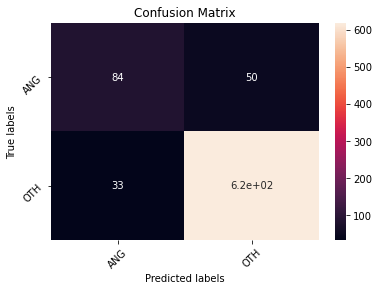

In [16]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getEmotion(x))
    predict_labeled.append(getEmotion(y))

labels = ['ANG','OTH']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);


In [17]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.8944020356234097


In [18]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

         ANG       0.72      0.63      0.67       134
         OTH       0.93      0.95      0.94       652

    accuracy                           0.89       786
   macro avg       0.82      0.79      0.80       786
weighted avg       0.89      0.89      0.89       786



<h2>K-Fold Training and Evaluation</h2>

In [19]:
folder = "models"
mode_version = "male_ang_oth_v_1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/male_ang_oth_v_1


In [20]:
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

In [21]:
#This will clone the model, but use new layers - we can reset these without affective the saved ones
model2 = tf.keras.models.clone_model(model)
model2.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=2

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    reset_weights(model2) #Reset the model before training
    history = model2.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    model2.save(model_file) #Save the model
    
    count+=1




Original trainingset shape [('ANG', 483), ('OTH', 2346)]
Resampled training set shape [('ANG', 2346), ('OTH', 2346)]
After OverSampling
X_train: shape=  (4692, 109, 167, 1)
Y_train: shape=  (4692, 2)
Epoch 1/100
587/587 - 13s - loss: 0.4964 - accuracy: 0.7677 - val_loss: 0.5466 - val_accuracy: 0.7599
Epoch 2/100
587/587 - 4s - loss: 0.4035 - accuracy: 0.8254 - val_loss: 0.3907 - val_accuracy: 0.8277
Epoch 3/100
587/587 - 4s - loss: 0.3732 - accuracy: 0.8431 - val_loss: 1.1708 - val_accuracy: 0.8291
Epoch 4/100
587/587 - 4s - loss: 0.3735 - accuracy: 0.8446 - val_loss: 0.3946 - val_accuracy: 0.8291
Epoch 5/100
587/587 - 4s - loss: 0.3378 - accuracy: 0.8589 - val_loss: 0.7007 - val_accuracy: 0.8277
Epoch 6/100
587/587 - 5s - loss: 0.3553 - accuracy: 0.8521 - val_loss: 2.4294 - val_accuracy: 0.1751
Epoch 7/100
587/587 - 4s - loss: 0.3415 - accuracy: 0.8625 - val_loss: 1.4270 - val_accuracy: 0.8291
Epoch 8/100
587/587 - 4s - loss: 0.3314 - accuracy: 0.8668 - val_loss: 4.0998 - val_accuracy

models/male_ang_oth_v_1_iter_2.model
INFO:tensorflow:Assets written to: models/male_ang_oth_v_1_iter_2.model/assets
Original trainingset shape [('ANG', 483), ('OTH', 2346)]
Resampled training set shape [('ANG', 2346), ('OTH', 2346)]
After OverSampling
X_train: shape=  (4692, 109, 167, 1)
Y_train: shape=  (4692, 2)
Epoch 1/100
587/587 - 4s - loss: 0.5198 - accuracy: 0.7577 - val_loss: 3.2509 - val_accuracy: 0.1709
Epoch 2/100
587/587 - 4s - loss: 0.4094 - accuracy: 0.8276 - val_loss: 2.8213 - val_accuracy: 0.1723
Epoch 3/100
587/587 - 4s - loss: 0.3798 - accuracy: 0.8480 - val_loss: 0.3033 - val_accuracy: 0.8884
Epoch 4/100
587/587 - 4s - loss: 0.3620 - accuracy: 0.8514 - val_loss: 0.2851 - val_accuracy: 0.9082
Epoch 5/100
587/587 - 4s - loss: 0.3502 - accuracy: 0.8589 - val_loss: 5.8825 - val_accuracy: 0.1709
Epoch 6/100
587/587 - 5s - loss: 0.3202 - accuracy: 0.8672 - val_loss: 0.2530 - val_accuracy: 0.9082
Epoch 7/100
587/587 - 4s - loss: 0.3249 - accuracy: 0.8711 - val_loss: 0.4331 

Epoch 13/100
587/587 - 4s - loss: 0.2612 - accuracy: 0.8941 - val_loss: 2.9955 - val_accuracy: 0.1737
Epoch 14/100
587/587 - 4s - loss: 0.2665 - accuracy: 0.8979 - val_loss: 0.4351 - val_accuracy: 0.8121
Epoch 15/100
587/587 - 4s - loss: 0.2366 - accuracy: 0.9064 - val_loss: 1.2605 - val_accuracy: 0.8460
Epoch 16/100
587/587 - 4s - loss: 0.2190 - accuracy: 0.9205 - val_loss: 4.2513 - val_accuracy: 0.1709
Epoch 17/100
587/587 - 4s - loss: 0.2093 - accuracy: 0.9165 - val_loss: 0.3023 - val_accuracy: 0.8856
Epoch 18/100
587/587 - 4s - loss: 0.2067 - accuracy: 0.9214 - val_loss: 0.9236 - val_accuracy: 0.8531
Epoch 19/100
587/587 - 5s - loss: 0.1953 - accuracy: 0.9327 - val_loss: 1.1020 - val_accuracy: 0.8390
Epoch 20/100
587/587 - 4s - loss: 0.1718 - accuracy: 0.9422 - val_loss: 0.8927 - val_accuracy: 0.6963
Epoch 21/100
587/587 - 4s - loss: 0.1783 - accuracy: 0.9369 - val_loss: 1.1538 - val_accuracy: 0.4746
Epoch 22/100
587/587 - 4s - loss: 0.1651 - accuracy: 0.9405 - val_loss: 0.4557 - v

Epoch 12/100
587/587 - 6s - loss: 0.2840 - accuracy: 0.8905 - val_loss: 0.6336 - val_accuracy: 0.8305
Epoch 13/100
587/587 - 6s - loss: 0.2666 - accuracy: 0.8986 - val_loss: 0.3733 - val_accuracy: 0.8573
Epoch 14/100
587/587 - 6s - loss: 0.2551 - accuracy: 0.9017 - val_loss: 0.4829 - val_accuracy: 0.8672
Epoch 15/100
587/587 - 6s - loss: 0.2459 - accuracy: 0.9066 - val_loss: 0.2861 - val_accuracy: 0.8983
Epoch 16/100
587/587 - 6s - loss: 0.2414 - accuracy: 0.9113 - val_loss: 0.4710 - val_accuracy: 0.8743
Epoch 17/100
587/587 - 6s - loss: 0.2252 - accuracy: 0.9130 - val_loss: 0.3366 - val_accuracy: 0.8814
Epoch 18/100
587/587 - 6s - loss: 0.1967 - accuracy: 0.9256 - val_loss: 1.3456 - val_accuracy: 0.5014
Epoch 19/100
587/587 - 6s - loss: 0.2234 - accuracy: 0.9224 - val_loss: 0.8813 - val_accuracy: 0.8446
Epoch 20/100
587/587 - 6s - loss: 0.1969 - accuracy: 0.9284 - val_loss: 0.4470 - val_accuracy: 0.8771
Epoch 21/100
587/587 - 6s - loss: 0.1935 - accuracy: 0.9329 - val_loss: 1.8240 - v

Epoch 2/100
587/587 - 10s - loss: 0.4138 - accuracy: 0.8225 - val_loss: 1.3433 - val_accuracy: 0.8291
Epoch 3/100
587/587 - 10s - loss: 0.3760 - accuracy: 0.8359 - val_loss: 4.0507 - val_accuracy: 0.1751
Epoch 4/100
587/587 - 10s - loss: 0.3544 - accuracy: 0.8474 - val_loss: 0.4811 - val_accuracy: 0.8432
Epoch 5/100
587/587 - 10s - loss: 0.3464 - accuracy: 0.8600 - val_loss: 3.7455 - val_accuracy: 0.1709
Epoch 6/100
587/587 - 10s - loss: 0.3212 - accuracy: 0.8715 - val_loss: 0.5987 - val_accuracy: 0.8305
Epoch 7/100
587/587 - 10s - loss: 0.3164 - accuracy: 0.8753 - val_loss: 1.0580 - val_accuracy: 0.8305
Epoch 8/100
587/587 - 10s - loss: 0.3092 - accuracy: 0.8708 - val_loss: 0.4384 - val_accuracy: 0.8291
Epoch 9/100
587/587 - 10s - loss: 0.2984 - accuracy: 0.8830 - val_loss: 2.5719 - val_accuracy: 0.1864
Epoch 10/100
587/587 - 10s - loss: 0.2839 - accuracy: 0.8853 - val_loss: 0.7104 - val_accuracy: 0.8630
Epoch 11/100
587/587 - 10s - loss: 0.2825 - accuracy: 0.8864 - val_loss: 0.9696 -

## Load and Evaluate

In [23]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=2

In [24]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    print('File Name Loaded: ',model_file)
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getEmotion(x))
        predict_labeled.append(getEmotion(y))
        
    labels = ['ANG','OTH']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    

File Name Loaded:  models/male_ang_oth_v_1_iter_1.model
File Name Loaded:  models/male_ang_oth_v_1_iter_2.model
File Name Loaded:  models/male_ang_oth_v_1_iter_3.model
File Name Loaded:  models/male_ang_oth_v_1_iter_4.model
File Name Loaded:  models/male_ang_oth_v_1_iter_5.model
File Name Loaded:  models/male_ang_oth_v_1_iter_6.model
File Name Loaded:  models/male_ang_oth_v_1_iter_7.model
File Name Loaded:  models/male_ang_oth_v_1_iter_8.model
File Name Loaded:  models/male_ang_oth_v_1_iter_9.model
File Name Loaded:  models/male_ang_oth_v_1_iter_10.model


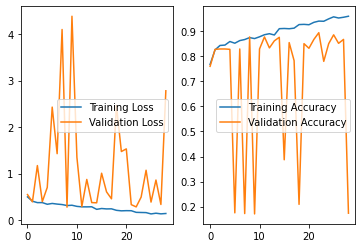

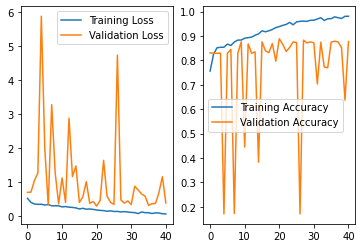

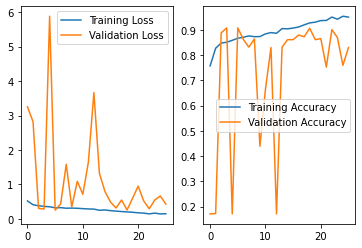

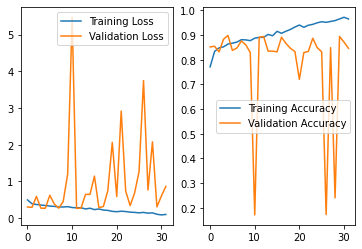

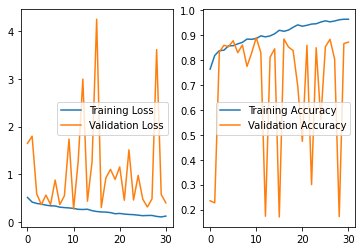

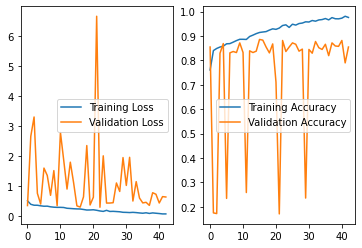

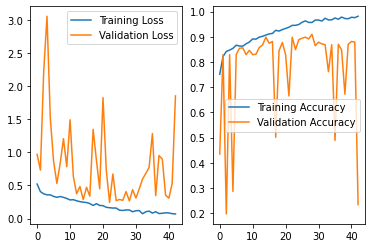

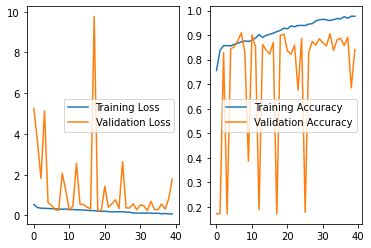

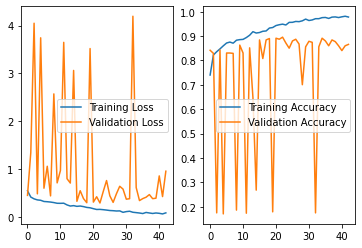

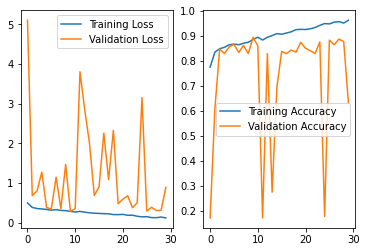

In [25]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [26]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.91464316 0.72380538]
precision sdev by class [0.01796349 0.0807679 ]
macro precision mean 0.8192242699276913
macro precision sdev 0.04077373035499687
recall mean [0.95337046 0.56477173]
recall sdev [0.02042411 0.10527298]
macro recall mean 0.7590710936752265
macro recall sdev 0.04779452483754188
f1 mean [0.93330893 0.62623276]
f1 sdev [0.00958014 0.07137086]
macro f1 mean 0.7797708426634915
macro f1 sdev 0.03947398551573607
accuracy mean 0.8870229007633588
accuracy sdev 0.016380129200438766


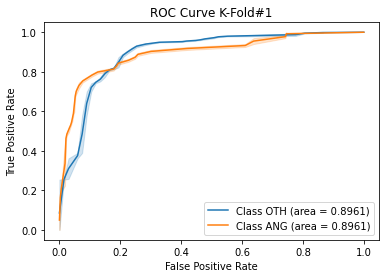

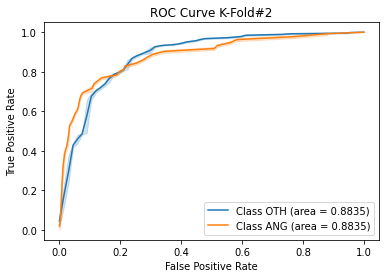

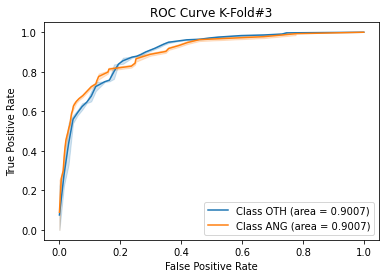

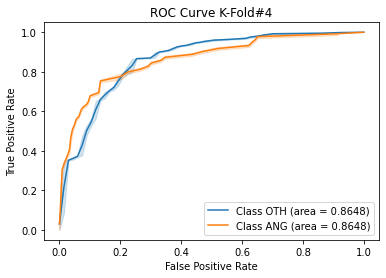

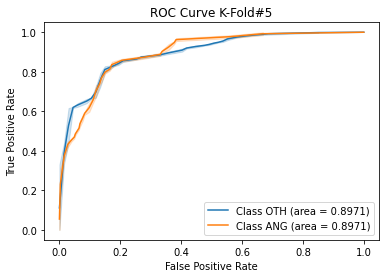

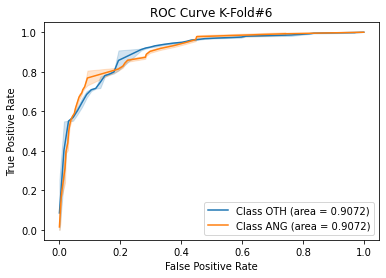

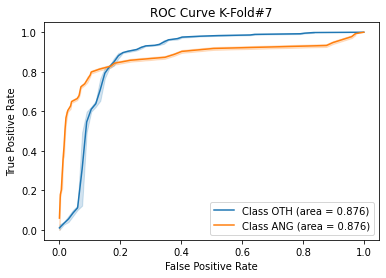

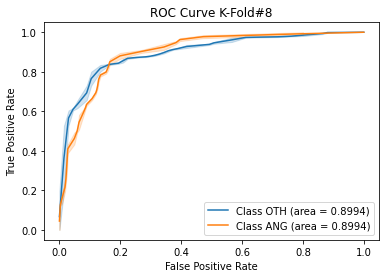

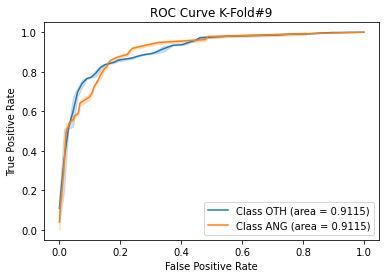

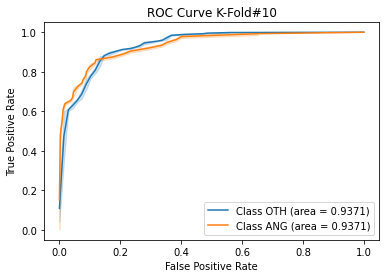

In [27]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getEmotion(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [28]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getEmotion(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  OTH
AUC Mean  0.8973203711890537
Std  0.018994163549698115
Sp:  ANG
AUC Mean  0.8973226603567124
Std  0.01899535233901315


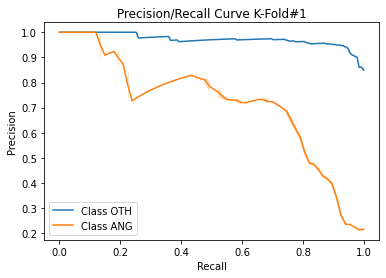

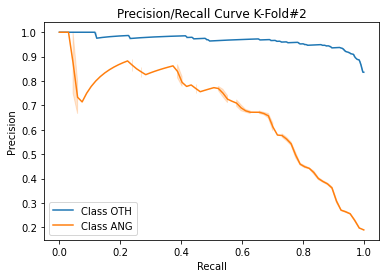

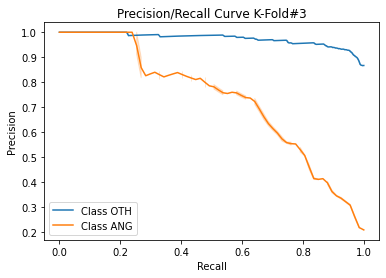

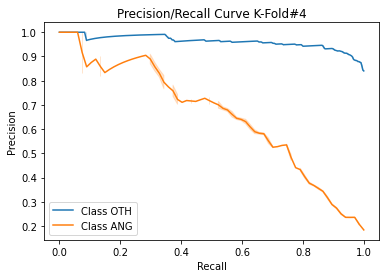

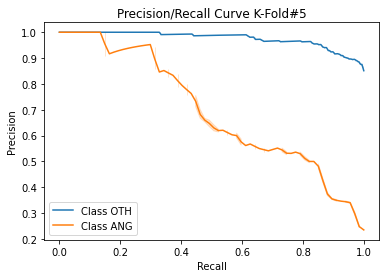

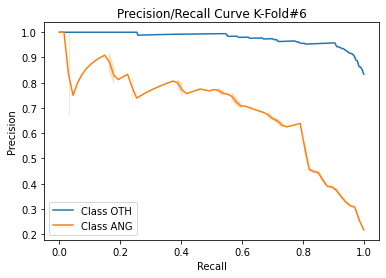

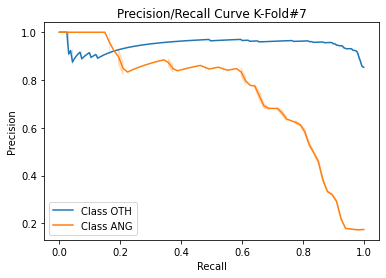

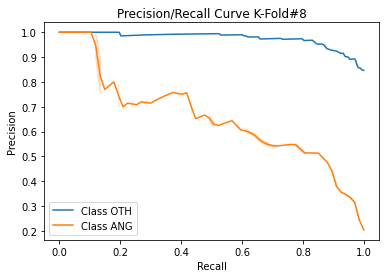

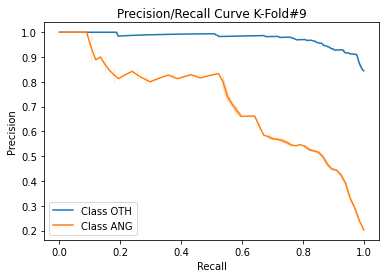

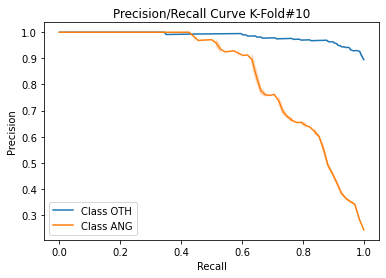

In [29]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getEmotion(j), legend='brief')

Confusion Matrix K-Fold #1

[[ 47  20]
 [ 18 308]]


Confusion Matrix K-Fold #2

[[ 33  34]
 [ 10 316]]


Confusion Matrix K-Fold #3

[[ 46  21]
 [ 26 300]]


Confusion Matrix K-Fold #4

[[ 25  42]
 [  8 318]]


Confusion Matrix K-Fold #5

[[ 34  33]
 [ 20 306]]


Confusion Matrix K-Fold #6

[[ 34  33]
 [ 10 316]]


Confusion Matrix K-Fold #7

[[ 44  23]
 [ 17 309]]


Confusion Matrix K-Fold #8

[[ 31  36]
 [ 16 310]]


Confusion Matrix K-Fold #9

[[ 44  23]
 [ 23 303]]


Confusion Matrix K-Fold #10

[[ 41  27]
 [  4 321]]




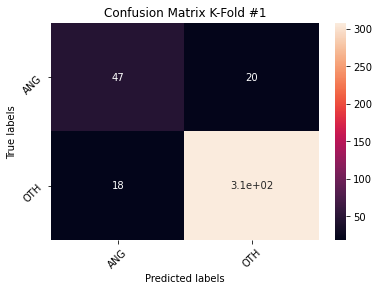

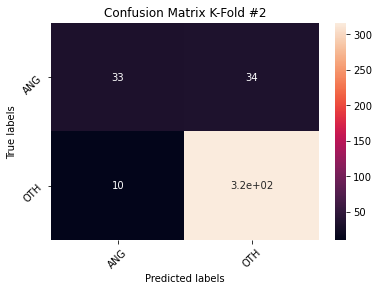

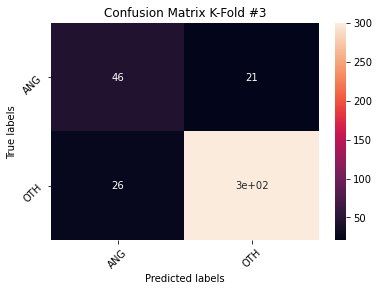

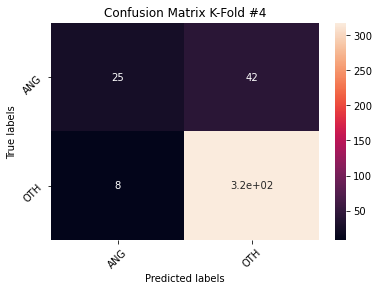

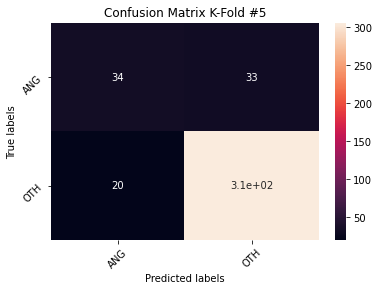

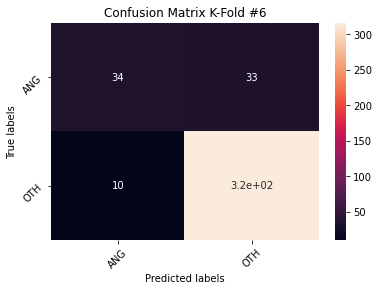

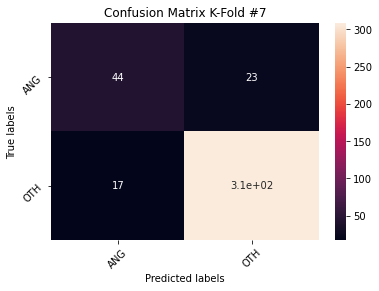

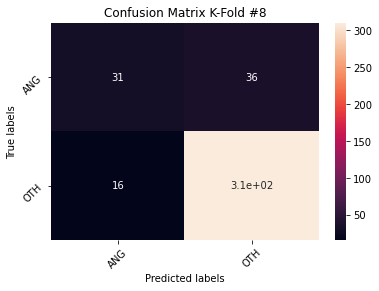

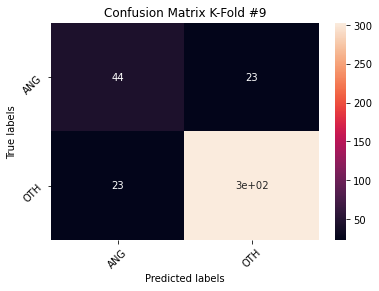

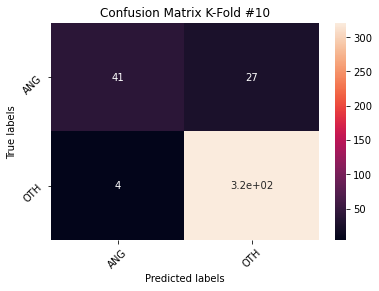

In [30]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[ 379  292]
 [ 152 3107]]

average of all confuion matrices
 [[ 37  29]
 [ 15 310]]


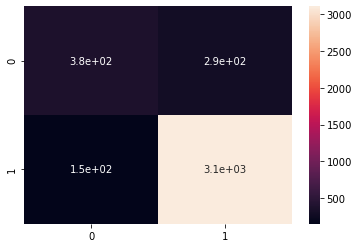

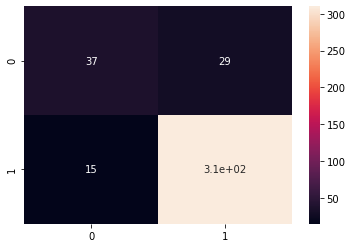

In [31]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.56 0.44]
 [0.05 0.95]]


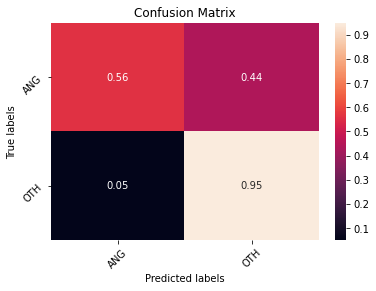

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['ANG','OTH']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);